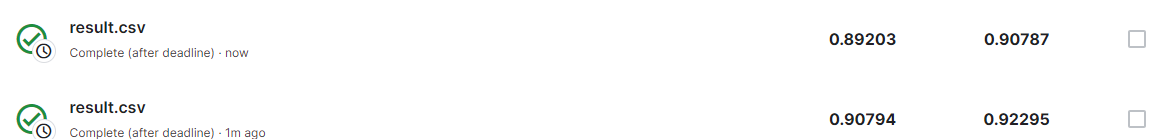

### 에포크 90, 100

In [1]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf


### 이미지 전처리

In [2]:
IMAGE_SIZE = (400, 400)

IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"
#SUB_PATH = "./plant-pathology-2020-fgvc7/sample_submission.csv"

test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    
    # 이미지 크기 확인
    height, width, _ = image.shape

    # 이미지를 224, 224로 줄이기
    image = cv2.resize(image, IMAGE_SIZE)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

images = train_data["image_id"][:].apply(load_image)



In [3]:
images = np.stack(images)
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values

In [5]:
"""
BATCH_SIZE = 4
LEARNING_RATE = 0.00025
K_NUM= 1

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
efmodel = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape= (IMAGE_SIZE[1], IMAGE_SIZE[0], 3))
model = Sequential()
model.add(efmodel)
model.add(Flatten())
model.add(Dense(128, activation='leaky_relu'))
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
"""

24274472/24274472 [==============================] - 2s 0us/step


In [6]:
BATCH_SIZE = 4
LEARNING_RATE = 0.00025
K_NUM= 1

model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), input_shape=(IMAGE_SIZE[1],IMAGE_SIZE[0],3), activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3),activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3),activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 64)       0

In [7]:
y_categorical = np.argmax(labels, axis=1)
k = 5  # Number of folds
stratified_kfold = StratifiedKFold(n_splits=k)

history = None
for i, (train_indices, test_indices) in enumerate(stratified_kfold.split(images, y_categorical)):
    if i != K_NUM:
        continue
        
    train_images, val_images = images[train_indices], images[test_indices]
    train_labels, val_labels = labels[train_indices], labels[test_indices]

    train_datagen = ImageDataGenerator(
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   fill_mode='nearest'
                                   )

    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=BATCH_SIZE, shuffle=True)
    val_generator = train_datagen.flow(x=val_images, y=val_labels, batch_size=BATCH_SIZE, shuffle=True)
    
    modelpath = f'./model/train9/kfold{i}/'
    modelname = 'epoch{epoch}.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath+modelname, monitor='val_loss', verbose=1, save_freq='epoch')
    #early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(train_generator, epochs=100, verbose=1, callbacks=[checkpointer], validation_data=val_generator)

Epoch 1/100
365/365 [==============================] - ETA: 0s - loss: 3.7842 - accuracy: 0.3768
Epoch 1: saving model to ./model/train9/kfold1\epoch1.hdf5
365/365 [==============================] - 39s 97ms/step - loss: 3.7842 - accuracy: 0.3768 - val_loss: 1.8986 - val_accuracy: 0.3022
Epoch 2/100
365/365 [==============================] - ETA: 0s - loss: 1.3847 - accuracy: 0.4393
Epoch 2: saving model to ./model/train9/kfold1\epoch2.hdf5
365/365 [==============================] - 35s 97ms/step - loss: 1.3847 - accuracy: 0.4393 - val_loss: 1.1554 - val_accuracy: 0.5055
Epoch 3/100
365/365 [==============================] - ETA: 0s - loss: 1.2102 - accuracy: 0.4990
Epoch 3: saving model to ./model/train9/kfold1\epoch3.hdf5
365/365 [==============================] - 35s 97ms/step - loss: 1.2102 - accuracy: 0.4990 - val_loss: 1.1648 - val_accuracy: 0.5027
Epoch 4/100
365/365 [==============================] - ETA: 0s - loss: 1.0069 - accuracy: 0.5937
Epoch 4: saving model to ./model/tra

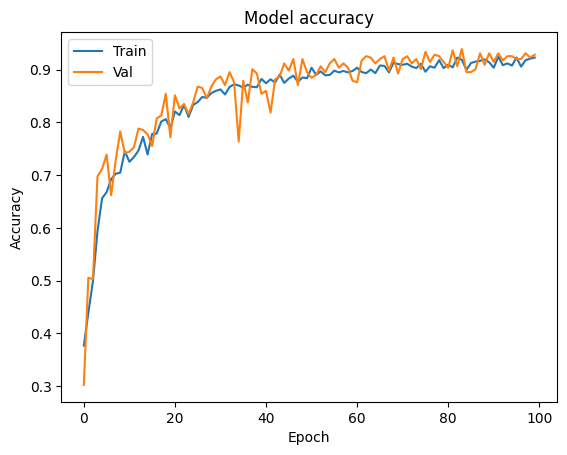

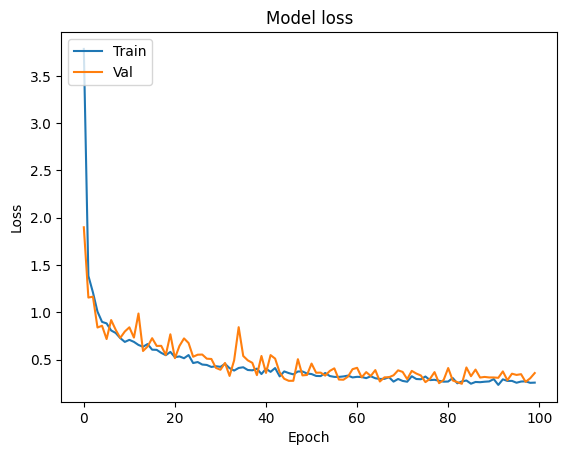

In [8]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()